In [39]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict ,Annotated
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.prompts import PromptTemplate
import operator
from pydantic import BaseModel, Field


In [40]:
load_dotenv()
model = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
)

In [41]:
class EvaluateSchema(BaseModel):
    feedback:str=Field(description="detailed feedback on the essay")
    score:int = Field(description="Score out of 10",ge=0, le=10)


In [14]:
structure_model = model.with_structured_output(EvaluateSchema)

In [27]:
essay="""Role of India in the AI World
Introduction
Artificial Intelligence (AI) has emerged as a transformative technology, shaping industries, economies, and societies worldwide. As the world enters an era of rapid technological change, India, with its vast talent pool and thriving technology ecosystem, is playing an increasingly influential role in the global AI landscape. India's participation in AI is not just limited to consumption but extends to innovation, research, policy-making, and ethical AI development.

India Strength in AI Talent
India is home to one of the largest pools of technology professionals in the world. With millions of skilled engineers, data scientists, and AI specialists, India has become a hub for AI development. The country produces thousands of graduates each year in computer science, machine learning, and AI-related fields from top institutions like the IITs, NITs, and IIITs. This abundant talent provides a strong foundation for India leadership in AI research and industrial application.

Government Initiatives to Promote AI
Recognizing AI's potential, the Government of India has launched several initiatives to make the country a global AI powerhouse. Programs like “National AI Mission”, “AI for All”, and “Responsible AI for Social Empowerment (RAISE)” aim to develop AI in a way that benefits all sections of society. NITI Aayog, India’s premier policy think tank, has been actively promoting AI to drive inclusive growth in key sectors such as healthcare, agriculture, education, smart mobility, and financial services.

Start-up Ecosystem and Industry Participation
India’s start-up ecosystem is booming, with many AI-focused startups emerging across sectors. From AI-powered healthcare diagnostics to precision agriculture, Indian startups are creating innovative solutions to local and global problems. Major Indian IT companies like Infosys, TCS, Wipro, and HCL are heavily investing in AI-based solutions and exporting AI services globally. Multinational companies have also set up AI research labs in India, making the country a global outsourcing destination for AI talent and services.

AI for Social Good
One of the most significant roles India plays in the AI world is its focus on AI for social good. India is leveraging AI to address fundamental challenges such as improving crop yields, predicting diseases, reducing traffic congestion, and making financial services accessible to underserved populations. The use of AI in governance, smart cities, and disaster management further highlights India’s commitment to using AI ethically and responsibly.

Challenges and Opportunities
Despite its potential, India faces challenges like limited infrastructure, data privacy concerns, and the need for upskilling a large workforce. However, these challenges also present opportunities. By focusing on inclusive AI education, building robust AI infrastructure, and promoting ethical AI usage, India can position itself as a global leader not just in AI innovation but also in AI governance.

Conclusion
India’s role in the AI world is rapidly evolving. From being a service provider to becoming an innovation leader, India is making significant contributions to the development and responsible use of AI. With the right investments, policy frameworks, and focus on human-centric AI, India has the potential to shape the future of AI globally, driving not just economic growth but also social welfare and equity."""

In [72]:
class UPSEWorkflowState(TypedDict):
    essay: str
    language_feedback:str
    analysis_feedback:str
    clarity_feedback:str
    evaluation_feedback:str
    individual_score:Annotated[list[int] , operator.add ]
    avg_score:float

In [73]:
def evaluate_lang(state:UPSEWorkflowState):
    prompt= f"Evaluate the language quality of the folowing essay and provide detailed feedback and assign score out of 10:\n\n{essay}"
    output = structure_model.invoke(prompt)
    return {"language_feedback": output.feedback, "individual_score": [output.score]}


In [74]:
def evaluate_analysis(state:UPSEWorkflowState):
    prompt= f"Evaluate the depth of analysis of the folowing essay and provide detailed feedback and assign score out of 10:\n\n{essay}"
    output = structure_model.invoke(prompt)
    return {"analysis_feedback": output.feedback, "individual_score": [output.score]}


In [75]:
def evaluate_thought(state:UPSEWorkflowState):
    prompt= f"Evaluate the clarity of thought of the folowing essay and provide detailed feedback and assign score out of 10:\n\n{essay}"
    output = structure_model.invoke(prompt)
    return {"clarity_feedback": output.feedback, "individual_score": [output.score]}


In [89]:
def final_evaluation(state:UPSEWorkflowState):
    total_score = sum(state['individual_score'])
    average_score = total_score / len(state['individual_score']) 
    prompt = f"Based on the following feedbacks create a summarized feedback:\nLanguage Feedback: {state['language_feedback']}\nAnalysis Feedback: {state['analysis_feedback']}\nClarity Feedback: {state['clarity_feedback']}\nAverage Score: {average_score:.2f}/10"
    output = model.invoke(prompt).content
    return {"evaluation_feedback": output, "avg_score": average_score}

In [90]:
graph = StateGraph(UPSEWorkflowState)

graph.add_node("evaluate_lang",evaluate_lang)
graph.add_node("evaluate_analysis",evaluate_analysis)
graph.add_node("evaluate_thought",evaluate_thought)
graph.add_node("final_evaluation",final_evaluation)

graph.add_edge(START, "evaluate_lang")
graph.add_edge(START,"evaluate_analysis")
graph.add_edge(START,"evaluate_thought")
graph.add_edge("evaluate_lang", "final_evaluation")
graph.add_edge("evaluate_analysis", "final_evaluation")
graph.add_edge("evaluate_thought", "final_evaluation")
graph.add_edge("final_evaluation", END)


UPES_WORKFLOW = graph.compile()


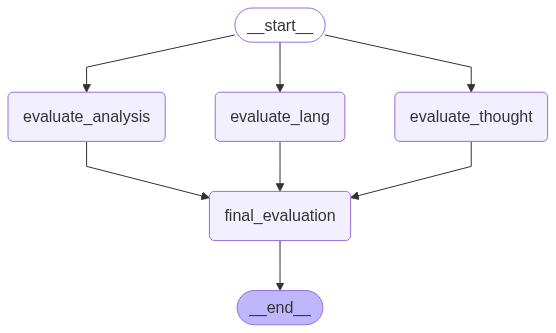

In [91]:
UPES_WORKFLOW

In [92]:
initial_state ={
    "essay": essay,
    "language_feedback": "",
    "analysis_feedback": "",
    "clarity_feedback": "",
    "evaluation_feedback": "",
    "individual_score": [],
    "avg_score": 0.0
}
result = UPES_WORKFLOW.invoke(initial_state)
result

{'essay': "Role of India in the AI World\nIntroduction\nArtificial Intelligence (AI) has emerged as a transformative technology, shaping industries, economies, and societies worldwide. As the world enters an era of rapid technological change, India, with its vast talent pool and thriving technology ecosystem, is playing an increasingly influential role in the global AI landscape. India's participation in AI is not just limited to consumption but extends to innovation, research, policy-making, and ethical AI development.\n\nIndia Strength in AI Talent\nIndia is home to one of the largest pools of technology professionals in the world. With millions of skilled engineers, data scientists, and AI specialists, India has become a hub for AI development. The country produces thousands of graduates each year in computer science, machine learning, and AI-related fields from top institutions like the IITs, NITs, and IIITs. This abundant talent provides a strong foundation for India leadership in